In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

In [ ]:
df = pd.read_csv('GE Amazon reviews.csv')
df.head()

,product_title,star_rating,verified_purchase,review_headline,review_body,review_date
0,GE MWF SmartWater Compatible Water Filter Cart...,5,Y,Five Stars,Super,8/31/15
1,GE MWF SmartWater Compatible Water Filter Cart...,5,Y,perfect fit - water tastes delicious,"Arrived when promised, perfect fit - water tas...",8/31/15
2,GE GPF65 Dishwasher Bracket Kit - Non Wood Cou...,5,Y,Five Stars,Perfect,8/31/15
3,GE WB44X5099 Oven Bake Element Fits GE & Hotpo...,5,Y,Five Stars,Great deal aaaa+,8/31/15
4,GE MWF SmartWater Compatible Water Filter Cart...,5,Y,Clean water,Fit as advertised. Just make sure to run a co...,8/31/15


In [ ]:
df['reviews']=df['review_headline']+' '+df['review_body']

In [ ]:
def classify(score):
    if score >= 4:
        return 1
    elif score <= 2:
        return -1
    else:
        return 0

In [ ]:
df['feedback'] = df['star_rating'].apply(classify)
df.head()

,product_title,star_rating,verified_purchase,review_headline,review_body,review_date,reviews,feedback
0,GE MWF SmartWater Compatible Water Filter Cart...,5,Y,Five Stars,Super,8/31/15,Five Stars Super,1
1,GE MWF SmartWater Compatible Water Filter Cart...,5,Y,perfect fit - water tastes delicious,"Arrived when promised, perfect fit - water tas...",8/31/15,perfect fit - water tastes delicious Arrived w...,1
2,GE GPF65 Dishwasher Bracket Kit - Non Wood Cou...,5,Y,Five Stars,Perfect,8/31/15,Five Stars Perfect,1
3,GE WB44X5099 Oven Bake Element Fits GE & Hotpo...,5,Y,Five Stars,Great deal aaaa+,8/31/15,Five Stars Great deal aaaa+,1
4,GE MWF SmartWater Compatible Water Filter Cart...,5,Y,Clean water,Fit as advertised. Just make sure to run a co...,8/31/15,Clean water Fit as advertised. Just make sure...,1


<Axes: xlabel='star_rating', ylabel='count'>

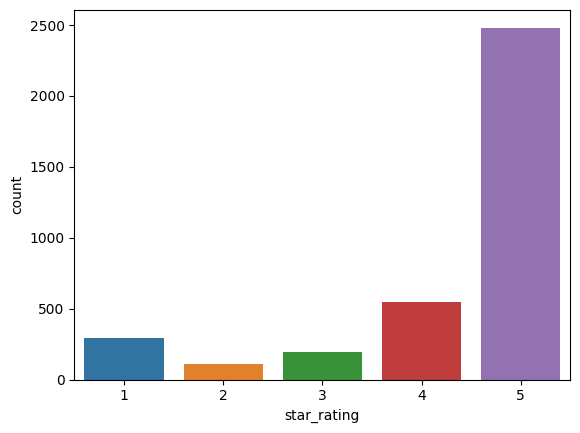

In [ ]:
sns.countplot(x = 'star_rating', data = df)

In [ ]:
top5 = df['product_title'].value_counts().head(5).index.tolist()

In [ ]:
top5

['GE MWF SmartWater Compatible Water Filter Cartridge - Refrigerator',
 'GE Gneral Electric DRYER LIGHT BULB WE4M305',
 'Genuine Aprilaire Humidifier Maintenance Kit 4839 - For Models 600, 600A, and 600M',
 'General Electric GENERAL ELECTRIC WD28X10177 SILVERWARE BASKET',
 'GE PHP900DMBB Profile 30" Black Electric Induction Cooktop']

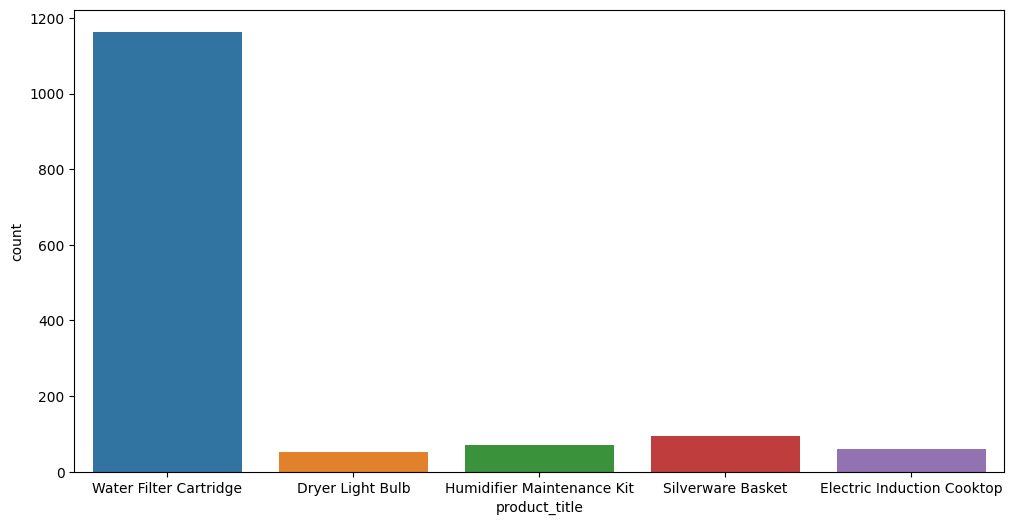

In [ ]:
new_label = ['Water Filter Cartridge', 'Dryer Light Bulb', 'Humidifier Maintenance Kit', 'Silverware Basket', 'Electric Induction Cooktop']
fig = plt.figure(figsize = (12,6))
sns.countplot(data=df[df['product_title'].isin(top5)], x='product_title')
plt.gca().set_xticklabels(new_label)
plt.show()

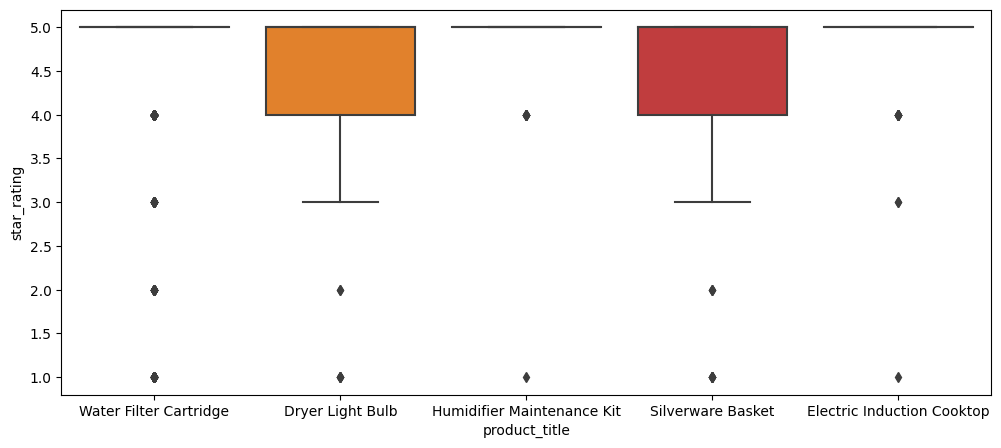

In [ ]:
fig = plt.figure(figsize = (12,5))
sns.boxplot(data=df[df['product_title'].isin(top5)], x='product_title', y = 'star_rating')
plt.gca().set_xticklabels(new_label)
plt.show()

#### Prepocessing text

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
def data_processing(text):
  text = text.lower()
  text = re.sub(r"http\S+www\S+|http\S+", '', text, flags=re.MULTILINE)
  text = re.sub(r'[^\w\s]','',text)
  text_tokens = word_tokenize(text)
  filtered_text = [w for w in text_tokens if not w in stop_words]
  return " ".join(filtered_text)

In [ ]:
df.reviews = df['reviews'].apply(data_processing)

In [ ]:
stemmer = PorterStemmer()
def stemming(data):
  text = [stemmer.stem(word) for word in data]
  return data

In [ ]:
df['reviews'] = df['reviews'].apply(lambda x: stemming(x))

In [ ]:
for i in range(5):
  print(df['reviews'].iloc[i],'\n')

five stars super 

perfect fit water tastes delicious arrived promised perfect fit water tastes delicious 

five stars perfect 

five stars great deal aaaa 

clean water fit advertised make sure run couple gallons directed 



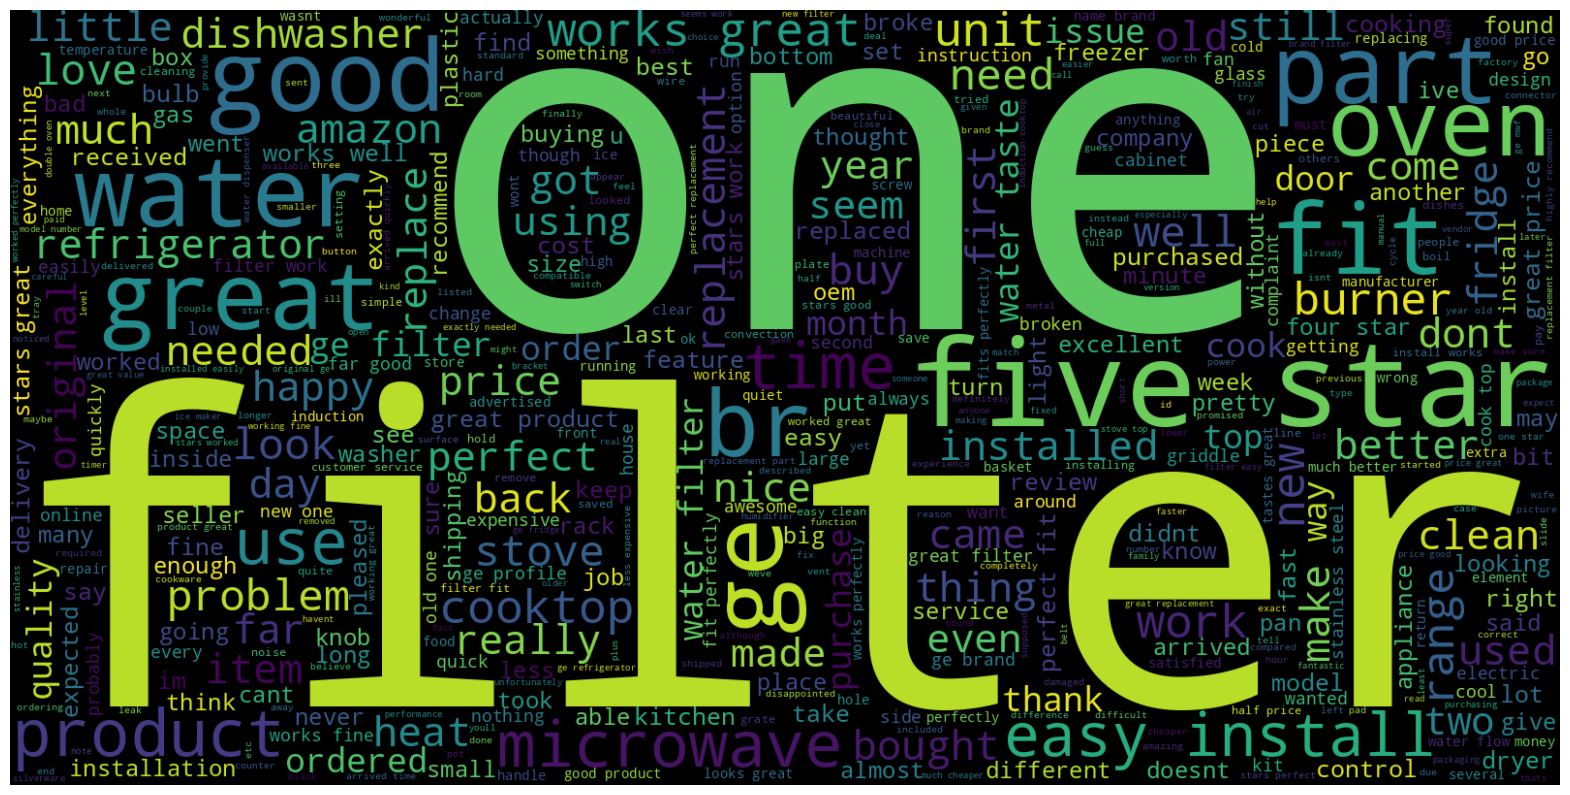

In [ ]:
text = ' '.join([word for word in df['reviews']])
plt.figure(figsize = (20,15), facecolor='None')
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
X = []
y = []
for i in df['reviews']:
  X.append(i)
for a in df['feedback']:
  y.append(a)

random.Random(799).shuffle(X)
random.Random(799).shuffle(y)

train_size = int(0.8*len(X))

X_train = X[:train_size]
y_train = y[:train_size]
X_valid = X[train_size:]
y_valid = y[train_size:]

In [ ]:
text_vec_padded = layers.TextVectorization(max_tokens=10000, output_mode="int", output_sequence_length=30)
text_vec_padded.adapt(X_train)

#### Simple RNN

In [ ]:
inputs = keras.Input(shape=(1), dtype='string')
x = text_vec_padded(inputs)
emb = layers.Embedding(input_dim=20000, output_dim=256)(x)
x = layers.SimpleRNN(units=16)(emb)
outputs = layers.Dense(units=1)(x)
simple_rnn = keras.Model(inputs=inputs, outputs=outputs)
simple_rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 256)           5120000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                4368      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 5,124,385
Trainable params: 5,124,385
Non-trainable params: 0
___________________________________________________

In [ ]:
simple_rnn.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
simple_rnn_res = simple_rnn.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
91/91 [==============================] - 20s 151ms/step - loss: 0.4524 - accuracy: 0.7431 - val_loss: -0.3106 - val_accuracy: 0.7975
Epoch 2/50
91/91 [==============================] - 7s 78ms/step - loss: -0.8373 - accuracy: 0.8309 - val_loss: 0.1212 - val_accuracy: 0.6667
Epoch 3/50
91/91 [==============================] - 6s 69ms/step - loss: -1.3147 - accuracy: 0.8719 - val_loss: -0.1451 - val_accuracy: 0.7259
Epoch 4/50
91/91 [==============================] - 7s 77ms/step - loss: -1.4354 - accuracy: 0.8791 - val_loss: 0.2297 - val_accuracy: 0.6928
Epoch 5/50
91/91 [==============================] - 5s 55ms/step - loss: -1.5386 - accuracy: 0.8819 - val_loss: 0.0859 - val_accuracy: 0.7479
Epoch 6/50
91/91 [==============================] - 6s 63ms/step - loss: -1.5624 - accuracy: 0.8871 - val_loss: 0.1634 - val_accuracy: 0.7645
Epoch 7/50
91/91 [==============================] - 4s 48ms/step - loss: -1.5715 - accuracy: 0.8871 - val_loss: 0.3298 - val_accuracy: 0.7328
Epo

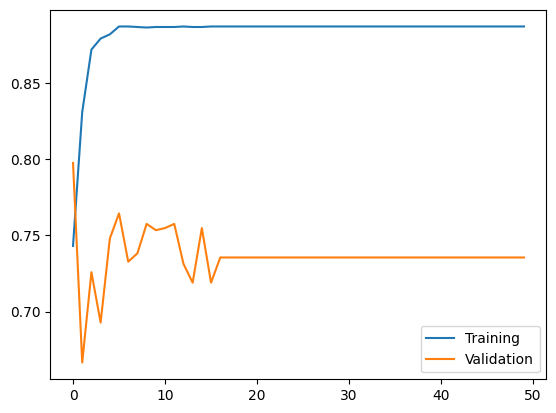

In [ ]:
plt.plot(simple_rnn_res.history['accuracy'], label='Training')
plt.plot(simple_rnn_res.history['val_accuracy'], label='Validation')

plt.legend()

#### LSTM

In [ ]:
inputs = keras.Input(shape=(1), dtype='string')
x = text_vec_padded(inputs)
emb = layers.Embedding(input_dim=20000, output_dim=256)(x)
x = layers.LSTM(units=16)(emb)
outputs = layers.Dense(1, activation='sigmoid')(x)
emb_model = keras.Model(inputs=inputs, outputs=outputs)
emb_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 30, 256)           5120000   
                                                                 
 lstm (LSTM)                 (None, 16)                17472     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,137,489
Trainable params: 5,137,489
Non-trainable params: 0
_________________________________________________

In [ ]:
emb_model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
emb_res = emb_model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
91/91 [==============================] - 12s 97ms/step - loss: 0.5515 - accuracy: 0.8378 - val_loss: 0.5543 - val_accuracy: 0.8209
Epoch 2/50
91/91 [==============================] - 5s 52ms/step - loss: 0.2628 - accuracy: 0.8140 - val_loss: 0.2045 - val_accuracy: 0.7493
Epoch 3/50
91/91 [==============================] - 3s 36ms/step - loss: 0.0014 - accuracy: 0.8347 - val_loss: 0.1572 - val_accuracy: 0.8127
Epoch 4/50
91/91 [==============================] - 2s 19ms/step - loss: -0.1926 - accuracy: 0.8530 - val_loss: 0.0804 - val_accuracy: 0.7934
Epoch 5/50
91/91 [==============================] - 2s 17ms/step - loss: -0.3630 - accuracy: 0.8612 - val_loss: 0.0714 - val_accuracy: 0.7837
Epoch 6/50
91/91 [==============================] - 2s 19ms/step - loss: -0.5364 - accuracy: 0.8629 - val_loss: -0.0476 - val_accuracy: 0.7865
Epoch 7/50
91/91 [==============================] - 1s 16ms/step - loss: -0.7705 - accuracy: 0.8681 - val_loss: -0.1038 - val_accuracy: 0.7906
Epoch 

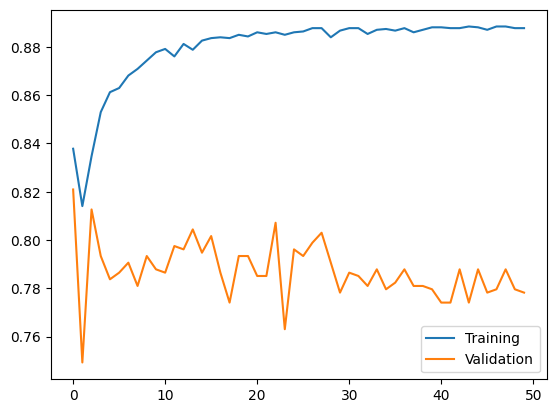

In [ ]:
plt.plot(emb_res.history['accuracy'], label='Training')
plt.plot(emb_res.history['val_accuracy'], label='Validation')

plt.legend()

#### Word2Vec

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=X, vector_size=200, window=5, min_count=5, workers=4)

In [ ]:
emb = []
for sentence in X:
    vectors = []
    for word in sentence:
        try:
            vectors.append(model.wv[word])
        except KeyError:
            pass
    if vectors:
        emb.append(np.mean(vectors, axis=0))
    else:
        emb.append(np.zeros(200))

In [ ]:
X_np = np.array(emb)

In [ ]:
train_size = int(0.8*len(X))

X_trn = X_np[:train_size]
X_val = X_np[train_size:]
print(X_trn.shape, X_val.shape)

(2904, 200) (726, 200)


In [ ]:
y_trn = np.array(y_train)
y_val = np.array(y_valid)

In [ ]:
inputs = keras.Input(shape=(200))
x = layers.Dense(units = 16, activation = 'relu')(inputs)
outputs = layers.Dense(1, activation='sigmoid')(x)
model0 = keras.Model(inputs=inputs, outputs=outputs)
model0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 16)                3216      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,233
Trainable params: 3,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model0.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
res = model0.fit(x=X_trn, y=y_trn, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
91/91 [==============================] - 1s 7ms/step - loss: 0.6059 - accuracy: 0.8357 - val_loss: 0.6079 - val_accuracy: 0.8182
Epoch 2/50
91/91 [==============================] - 1s 6ms/step - loss: 0.5706 - accuracy: 0.8392 - val_loss: 0.6033 - val_accuracy: 0.8182
Epoch 3/50
91/91 [==============================] - 0s 5ms/step - loss: 0.5628 - accuracy: 0.8392 - val_loss: 0.5934 - val_accuracy: 0.8182
Epoch 4/50
91/91 [==============================] - 1s 5ms/step - loss: 0.5553 - accuracy: 0.8392 - val_loss: 0.5855 - val_accuracy: 0.8182
Epoch 5/50
91/91 [==============================] - 1s 6ms/step - loss: 0.5477 - accuracy: 0.8392 - val_loss: 0.5749 - val_accuracy: 0.8182
Epoch 6/50
91/91 [==============================] - 0s 4ms/step - loss: 0.5399 - accuracy: 0.8388 - val_loss: 0.5668 - val_accuracy: 0.8168
Epoch 7/50
91/91 [==============================] - 0s 4ms/step - loss: 0.5328 - accuracy: 0.8375 - val_loss: 0.5609 - val_accuracy: 0.8168
Epoch 8/50
91/91 [==

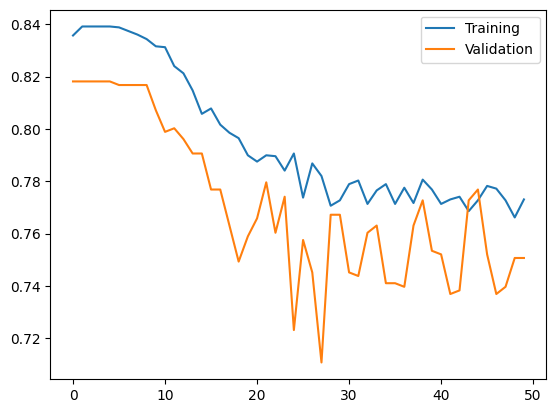

In [ ]:
plt.plot(res.history['accuracy'], label='Training')
plt.plot(res.history['val_accuracy'], label='Validation')

plt.legend()

In [ ]:
pred = emb_model.predict(X_valid)

23/23 [==============================] - 0s 3ms/step


In [ ]:
pred_reshape = pred.reshape(-1).astype(int)

In [ ]:
y_valid = np.array(y_valid)

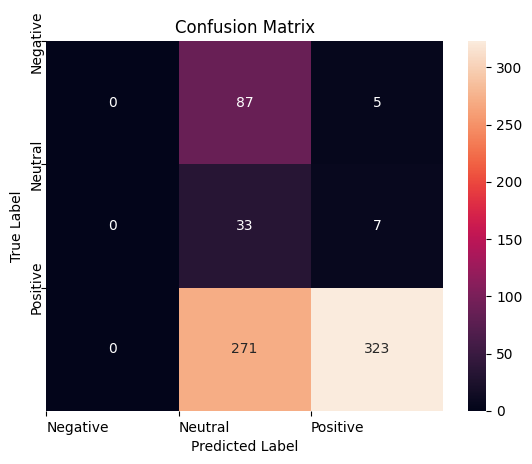

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, pred_reshape)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], ha="left")
plt.ylabel("True Label")
plt.yticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], ha="center")
plt.show()

In [ ]:
pred2 = model0.predict(X_val)

23/23 [==============================] - 0s 4ms/step


In [ ]:
pred2_reshape = pred2.reshape(-1).astype(int)

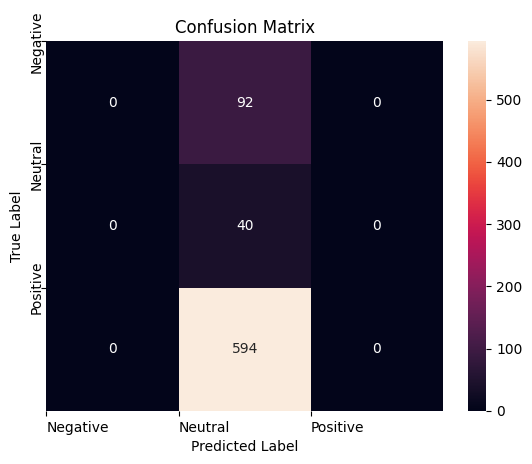

In [ ]:
cm2 = confusion_matrix(y_val, pred2_reshape)
sns.heatmap(cm2, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], ha="left")
plt.ylabel("True Label")
plt.yticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], ha="center")
plt.show()